In [1]:
from functions import *

# 1- Data Loading and visualisation

In [2]:
# ----------------------------- IMDB 4 scale  -----------------------------------------
df_submission = load_sub_data()
df_submission = df_submission
df_train = load_train_data()
df_train = df_train

2    79582
3    32927
1    27273
4     9206
0     7072
Name: sentiment, dtype: int64


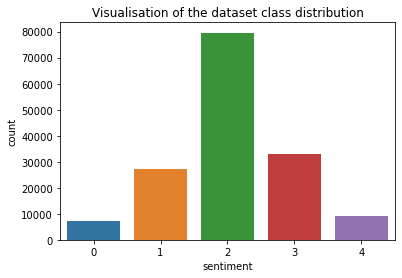

In [3]:
plot_class_distribution(df_train["sentiment"])

# 2- Data pre-processing

### Data cleaning 

In [4]:
df_train = data_cleaning(df_train)
df_submission = data_cleaning(df_submission)

### Transformation to TF-IDF features

In [5]:
# best_par = return_best_tfidf(df_train)

In [6]:
X_TfIdf = Tfidf_transformation(df_train,ngram_range=(1,1))
# X_TfIdf = Tfidf_transformation(df_train,ngram_range= best_par["tfidf__ngram_range"])

Before transformation: The data had shape:  (156060,)
After transformation: The data has shape:  (156060, 16056)


### Transformation to word2Vec features using gensim

In [ ]:
# X_word2Vec2 = load_pkl("./X_word2Vec.pkl")
X_word2Vec = word2Vec_transform(df_train,False)

# 3- Data partitionning

### Create sets using the original data

In [7]:
X_train,X_val,X_test,y_train,y_val,y_test = data_partitioning(df_train["review"].values,df_train["sentiment"].values,test_size=0.3,summary=True)

Overall class distribution in this dataset
2    55603
3    23114
1    19051
4     6420
0     5053
dtype: int64
2    11923
3     4973
1     4073
4     1416
0     1024
dtype: int64

X_train has shape: (109241,)
y_train has shape: (109241,)
X_val has shape: (23409,)
y_val has shape: (23409,)
X_test has shape: (23410,)
y_test has shape: (23410,)


### Create sets to be used when converted into TFIDF features

In [12]:
X_train_TfIdf,X_val_TfIdf,X_test_TfIdf,y_train_TfIdf,y_val_TfIdf,y_test_TfIdf = data_partitioning(X_TfIdf,df_train["sentiment"].values,test_size=0.3,summary=False)

### Create sets to be used when converted into Word2Vec features

In [13]:
X_train_word2Vec,X_val_word2Vec,X_test_word2Vec,y_train_word2Vec,y_val_word2Vec,y_test_word2Vec= data_partitioning(X_word2Vec,df_train["sentiment"].values,test_size=0.3, summary=False)

### Create sets to be used when converted into BERT features

In [8]:
X_train_bert,X_val_bert,X_test_bert,y_train_bert,y_val_bert,y_test_bert = data_partitioning(df_train["review"].values,df_train["sentiment"].values,test_size=0.3,summary=False)

# 4- Inference step using Logistic regression

### Sentiment prediction using TF-IDF embeddings

Fitting accuracy
**************************
0.753934191702432
Prediction accuracy
**************************
0.7417218543046358

************************************************************
                 LR classification report
************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.33      0.50        21
           2       0.74      0.98      0.85       104
           3       0.43      0.16      0.23        19
           4       0.00      0.00      0.00         6

    accuracy                           0.74       151
   macro avg       0.43      0.29      0.32       151
weighted avg       0.71      0.74      0.68       151



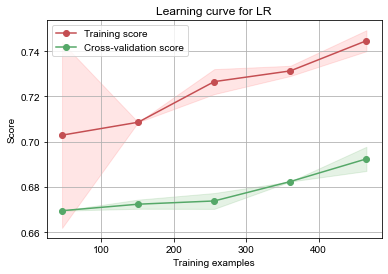

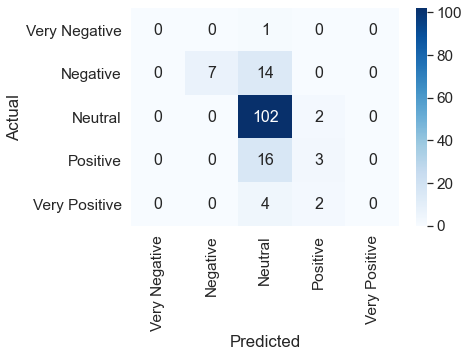

In [15]:
LR_predict(X_train_TfIdf,y_train_TfIdf,X_test_TfIdf,y_test_TfIdf)

### Dimensionality reduction using Truncated Singular Value Decomposition (TSVD)

Initial train matrix shape is:  (699, 533)
Initial test shape is:  (151, 533)
PCA transformed train shape is:  (699, 500)
PCA transformed test shape is:  (151, 500)


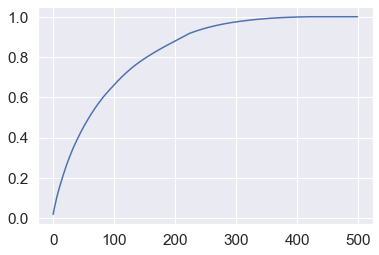

In [16]:
X_train_TfIdf,X_test_TfIdf,tsvd = apply_TSVD(X_train_TfIdf,X_test_TfIdf,True,500)    

### Sentiment prediction using TF-IDF embeddings after diemnsionality reduction

Fitting accuracy
**************************
0.753934191702432
Prediction accuracy
**************************
0.7417218543046358

************************************************************
                 LR classification report
************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.33      0.50        21
           2       0.74      0.98      0.85       104
           3       0.43      0.16      0.23        19
           4       0.00      0.00      0.00         6

    accuracy                           0.74       151
   macro avg       0.43      0.29      0.32       151
weighted avg       0.71      0.74      0.68       151



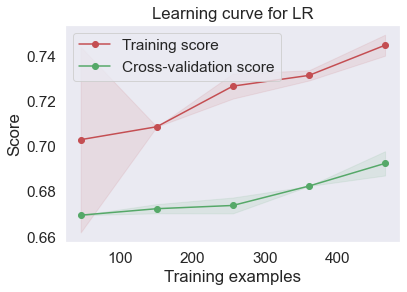

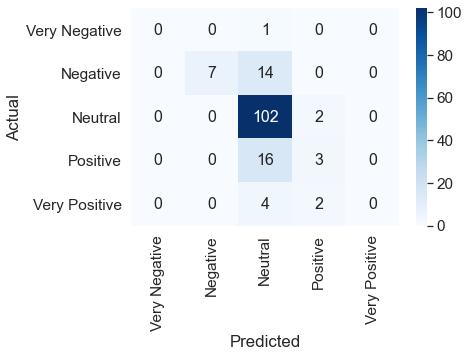

In [17]:
LR_predict(X_train_TfIdf,y_train_TfIdf,X_test_TfIdf,y_test_TfIdf)

### Sentiment prediction using Word2Vec embeddings

Fitting accuracy
**************************
0.7882689556509299
Prediction accuracy
**************************
0.6291390728476821

************************************************************
                 LR classification report
************************************************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.25      0.20      0.22        20
           2       0.74      0.82      0.77       103
           3       0.33      0.32      0.32        19
           4       0.33      0.20      0.25         5

    accuracy                           0.63       151
   macro avg       0.33      0.31      0.31       151
weighted avg       0.59      0.63      0.61       151



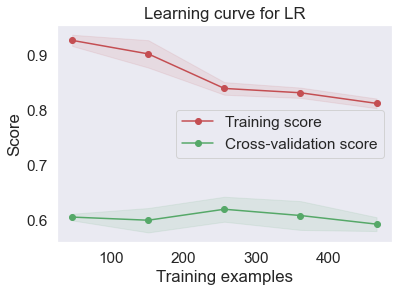

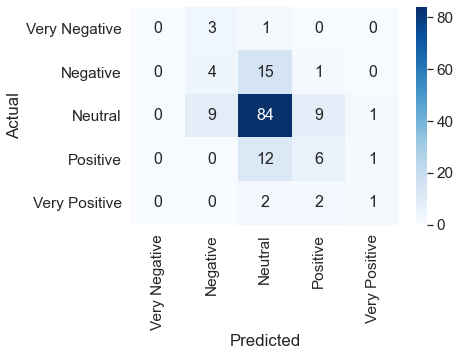

In [18]:
LR_predict(X_train_word2Vec,y_train_word2Vec,X_test_word2Vec,y_test_word2Vec)

# 5- Inference step using Deep Learning

### Data encoding and embedding layer creation with Word2vec Transfer Learning

In [17]:
EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE,w2v_model,embedding_matrix,X_train,X_val,X_test,X_submission = load_pretrained_embedding_model(df_train,
                                                                                                                                   df_submission, 
                                                                                                                                   X_train, 
                                                                                                                                   X_val,
                                                                                                                                   X_test,
                                                                                                                                   EMBEDDING_DIM = 300, 
                                                                                                                                   model = 'word2vec-google-news-300')

Maximum sentence lenght:  52
Found 19284 unique tokens in the dataset.
Loading word vectors from server...
Loading word vectors from local saved file...
Shape of X_train data tensor: (109241, 52)
Shape of X_val data tensor: (23409, 52)
Shape of X_test data tensor: (23410, 52)
Shape of X_submission data tensor: (66292, 52)
Filling pre-trained embeddings...
The final embedding matrix has shape:  (19285, 300)


In [18]:
embedding_layer = Embedding(MAX_VOCAB_SIZE,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## 1- Long-Short-Term-Memory (LSTM)

In [19]:
def simple_LSTM_model_multiclass(embedding_layer):
    simple_LSTM_model_multiclass = Sequential()
    simple_LSTM_model_multiclass.add(embedding_layer)
    simple_LSTM_model_multiclass.add(LSTM(128))
    simple_LSTM_model_multiclass.add(Dense(5, activation='softmax'))
    simple_LSTM_model_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                         optimizer=Adam(lr=1e-3),
                                         metrics=['accuracy'])
    simple_LSTM_model_multiclass.summary()
    return simple_LSTM_model_multiclass,"simple_LSTM_model_multiclass"

model, model_name = simple_LSTM_model_multiclass(embedding_layer) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           5785500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,005,793
Trainable params: 220,293
Non-trainable params: 5,785,500
_________________________________________________________________


In [20]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 10, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

Epoch 1/10
853/854 [============================>.] - ETA: 0s - loss: 1.0415 - accuracy: 0.5810

KeyboardInterrupt: 

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 2- BiLSTM with a Dense Layer and Dropout

In [ ]:
def simple_biLSTM_model_multiclass(embedding_layer):
    simple_biLSTM_model_multiclass = Sequential()
    simple_biLSTM_model_multiclass.add(embedding_layer)
    simple_biLSTM_model_multiclass.add(Bidirectional(LSTM(128)))
    simple_biLSTM_model_multiclass.add(Dense(128, activation='relu'))
    simple_biLSTM_model_multiclass.add(Dropout(0.5))
    simple_biLSTM_model_multiclass.add(Dense(5, activation='softmax'))
    simple_biLSTM_model_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    simple_biLSTM_model_multiclass.summary()
    return simple_biLSTM_model_multiclass,"simple_biLSTM_model_multiclass"

model, model_name = simple_biLSTM_model_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 11, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 3- Multiple layer lstm
 

In [27]:
def multi_layer_lstm_multiclass(embedding_layer):
    multi_layer_lstm_multiclass = Sequential()
    multi_layer_lstm_multiclass.add(embedding_layer)
    multi_layer_lstm_multiclass.add(Bidirectional(LSTM(128, return_sequences=True)))
    keras.layers.Dropout(0.5)
    multi_layer_lstm_multiclass.add(GlobalMaxPool1D())
    keras.layers.Dropout(0.5)
    multi_layer_lstm_multiclass.add(Dense(5, activation='softmax'))
    multi_layer_lstm_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    multi_layer_lstm_multiclass.summary()
    return multi_layer_lstm_multiclass,"multi_layer_lstm_multiclass"

model, model_name = multi_layer_lstm_multiclass(embedding_layer)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           5785500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 52, 256)           439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 6,226,081
Trainable params: 440,581
Non-trainable params: 5,785,500
_________________________________________________________________


Epoch 1/13
854/854 [==============================] - 16s 16ms/step - loss: 1.0531 - accuracy: 0.5828 - val_loss: 0.8808 - val_accuracy: 0.6395
Epoch 2/13
854/854 [==============================] - 12s 15ms/step - loss: 0.8686 - accuracy: 0.6446 - val_loss: 0.8546 - val_accuracy: 0.6498
Epoch 3/13
854/854 [==============================] - 13s 15ms/step - loss: 0.8212 - accuracy: 0.6653 - val_loss: 0.8376 - val_accuracy: 0.6547
Epoch 4/13
854/854 [==============================] - 13s 15ms/step - loss: 0.7875 - accuracy: 0.6800 - val_loss: 0.8168 - val_accuracy: 0.6650
Epoch 5/13
854/854 [==============================] - 13s 15ms/step - loss: 0.7507 - accuracy: 0.6960 - val_loss: 0.8079 - val_accuracy: 0.6688
Epoch 6/13
854/854 [==============================] - 13s 15ms/step - loss: 0.7162 - accuracy: 0.7110 - val_loss: 0.8001 - val_accuracy: 0.6713
Epoch 7/13
854/854 [==============================] - 13s 15ms/step - loss: 0.6855 - accuracy: 0.7244 - val_loss: 0.7995 - val_accuracy:

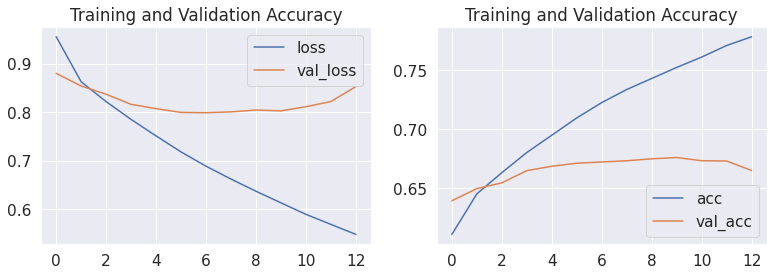

In [28]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

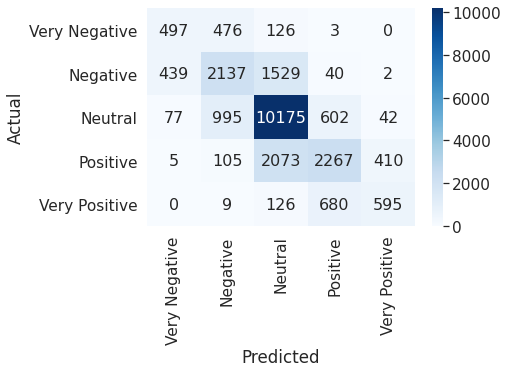

              precision    recall  f1-score   support

           0       0.49      0.45      0.47      1102
           1       0.57      0.52      0.54      4147
           2       0.73      0.86      0.79     11891
           3       0.63      0.47      0.54      4860
           4       0.57      0.42      0.48      1410

    accuracy                           0.67     23410
   macro avg       0.60      0.54      0.56     23410
weighted avg       0.66      0.67      0.66     23410



In [29]:
generate_pred(model,X_test,y_test)

In [30]:
submission = generate_submission(model,X_submission,model_name)
submission

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,0
66288,222349,0
66289,222350,1
66290,222351,1


## 4- Convolutional Neural network


In [ ]:
def simple_CNN_multiclass(embedding_layer):
    simple_CNN_multiclass = Sequential()
    simple_CNN_multiclass.add(embedding_layer)
    simple_CNN_multiclass.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
    simple_CNN_multiclass.add(GlobalMaxPool1D())
    simple_CNN_multiclass.add(Dense(256, activation='relu'))
    simple_CNN_multiclass.add(Dense(5, activation='softmax'))
    simple_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    simple_CNN_multiclass.summary()
    return simple_CNN_multiclass,"simple_CNN_multiclass"

model, model_name = simple_CNN_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 5- ELABORATED CNN WITH PARALLEL LAYERS AND DROPOUT
 

In [ ]:
def parallelized_CNN_multiclass(embedding_layer):
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    tweet_encoder = embedding_layer(input_)
    bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPool1D()(bigram_branch)
    trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPool1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
    fifthgram_branch = Conv1D(filters=100, kernel_size=5, padding='valid', activation='relu', strides=1)(tweet_encoder)
    fifthgram_branch = GlobalMaxPool1D()(fifthgram_branch)
    merged = concatenate([bigram_branch, trigram_branch,fourgram_branch,fifthgram_branch], axis=1)
    merged = Dropout(0.5)(merged)
    merged = Dense(5)(merged)
    output = Activation('softmax')(merged)
    parallelized_CNN_multiclass = Model(inputs=[input_], outputs=[output])

    parallelized_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    parallelized_CNN_multiclass.summary()
    return parallelized_CNN_multiclass,"parallelized_CNN_multiclass"

model, model_name = parallelized_CNN_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 6- Hybrid model: CNN-LSTM

In [ ]:
def hybrid_LSTM_CNN_multiclass(embedding_layer):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedded_sequences = embedding_layer(sequence_input)
    drop_out_1 = Dropout(0.5, name='drop_out_1')(embedded_sequences)
    biLSTM_1 = Bidirectional(LSTM(60, return_sequences=True))(embedded_sequences)
    conv_1 = Conv1D(128, 2, activation='relu', name='conv_1')(biLSTM_1)
    gmp_1 = GlobalMaxPool1D(name='gmp_1')(conv_1)
    conv_2 = Conv1D(128, 3, activation='relu', name='conv_2')(biLSTM_1)
    gmp_2 = GlobalMaxPool1D(name='gmp_2')(conv_2)
    conv_3 = Conv1D(128, 4, activation='relu', name='conv_3')(biLSTM_1)
    gmp_3 = GlobalMaxPool1D(name='gmp_3')(conv_3)

    concat = concatenate([gmp_1,gmp_2,gmp_3])
    # concat = concatenate([gmp_1,gmp_2])

    drop_out_2 = Dropout(0.5, name='drop_out_2')(concat)
    mp_dense = Dense(64, activation='relu', name='mp_dense')(drop_out_2)
    drop_out_3 = Dropout(0.5, name='drop_out_2')(mp_dense)
    
    preds = Dense(5, activation='softmax', name='preds')(mp_dense)
    hybrid_LSTM_CNN_multiclass = Model(sequence_input, preds)

    hybrid_LSTM_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    hybrid_LSTM_CNN_multiclass.summary()
    return hybrid_LSTM_CNN_multiclass,"hybrid_LSTM_CNN_multiclass"

model, model_name = hybrid_LSTM_CNN_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

# TRANSFORMERS

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def build_model(bert_layer, max_len=MAX_SEQUENCE_LENGTH):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model, "bert_model"

In [ ]:
# train_input = bert_encode(X_train.values, tokenizer, max_len=150)
# val_input = bert_encode(X_val.values, tokenizer, max_len=150)
# test_input = bert_encode(X_test.values, tokenizer, max_len=150)
# sub_input = bert_encode(df_submission.review.values, tokenizer, max_len=150)

# new_model = tf.keras.models.load_model('../input/test-models/model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# new_model.summary()

In [ ]:
train_input = bert_encode(X_train_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
val_input = bert_encode(X_val_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
test_input = bert_encode(X_test_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
sub_input = bert_encode(df_submission.review.values, tokenizer, max_len=MAX_SEQUENCE_LENGTH)

In [ ]:
model,model_name = build_model(bert_layer, max_len=MAX_SEQUENCE_LENGTH)

# bert_model = tf.keras.models.load_model('../input/test-models/model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# bert_model.summary()

In [ ]:
model = train_bert_model(model,
                        train_input,y_train_bert, 
                        val_input,y_val_bert,
                        BATCH_SIZE = 50, 
                        EPOCHS = 8, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

In [ ]:
generate_pred(model,test_input,y_test_bert)

In [ ]:
submission = generate_submission(model,sub_input,model_name)
submission